In [1]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt

2025-12-04 12:01:06.825603872 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card0/device/vendor"


In [2]:
ONNX_MODEL_PATH = "xception_faceforensics.onnx"
DIR_FAKE = "clean_data/fake/"
DIR_REAL = "clean_data/real/"

In [ ]:
def preprocess_image(img):

    # (299x299 for Xception)
    img = cv2.resize(img, (299, 299))

    # np + normalize
    # PyTorch/Xception (FaceForensics) : mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
    # Formule : (pixel / 255.0 - mean) / std
    img_data = np.array(img).astype(np.float32)
    img_data = (img_data / 255.0 - 0.5) / 0.5
    # img_data = (img_data / 255.0 - 0.5) * 2
    # change format from HWC (Height, Width, Channels) > CHW (Channels, Height, Width)
    # ONNX waits for NCHW
    img_data = img_data.transpose(2, 0, 1)

    # add batch dim (3, 299, 299) > (1, 3, 299, 299)
    img_data = np.expand_dims(img_data, axis=0)

    return img_data

In [4]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [ ]:
class ONNXModel:
    def __init__(self, model_path):
        print(f"Loading ONNX model : {model_path}")
        self.session = ort.InferenceSession(model_path)
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name

    def __call__(self, x):
        if x.dtype != np.float32:
            x = x.astype(np.float32)
            
        # Exécution de l'inférence
        outputs = self.session.run([self.output_name], {self.input_name: x})
        
        # On retourne directement les logits (comme PyTorch)
        return outputs[0]

In [ ]:
model = ONNXModel("xception_faceforensics.onnx")

Loading ONNX model : xception_faceforensics.onnx


In [7]:
real_imgs = []
fake_imgs = []

real_imgs_names = []
fake_imgs_names = []


print("loading real imgs")

for fname in os.listdir(DIR_REAL):
    path = os.path.join(DIR_REAL, fname)
    if 'png' not in path: continue
    img = Image.open(path).convert('RGB')
    img = np.array(img)
    real_imgs.append(img)
    real_imgs_names.append(fname)

print("loading fake imgs")

for fname in os.listdir(DIR_FAKE):
    path = os.path.join(DIR_FAKE, fname)
    if 'png' not in path: continue
    img = Image.open(path).convert('RGB')
    img = np.array(img)
    fake_imgs.append(img)
    fake_imgs_names.append(fname)

print(f"Successfully loaded {len(real_imgs)} real images and {len(fake_imgs)} real images")
min_len = min(len(real_imgs), len(fake_imgs))
print("Keeping the", min_len, "first images of each dataset")
real_imgs = real_imgs[:min_len]
fake_imgs = fake_imgs[:min_len]
fake_imgs_names = fake_imgs_names[:min_len]
real_imgs_names = real_imgs_names[:min_len]

loading real imgs
loading fake imgs
Successfully loaded 4508 real images and 4358 real images
Keeping the 4358 first images of each dataset


In [8]:
print(f"Pixels range: Min: {preprocess_image(real_imgs[0]).min():.2f}, Max: {preprocess_image(real_imgs[0]).max():.2f}, Mean: {preprocess_image(real_imgs[0]).mean():.2f}")

Pixels range: Min: -1.00, Max: 0.34, Mean: -0.49


In [9]:
### EVALUATION

In [10]:
logits = model(preprocess_image(fake_imgs[0]))
probs_fake = softmax(logits)[0][1]

logits = model(preprocess_image(real_imgs[0]))
probs_real = softmax(logits)[0][1]

print(f"probabilities on fake of being a deepfake : {probs_fake*100:.2f} %")
print(f"probabilities on real of being a deepfake : {probs_real*100:.2f} %")

probabilities on fake of being a deepfake : 60.10 %
probabilities on real of being a deepfake : 49.15 %


In [11]:
probas_fake = []   # actual fakes
probas_real = []   # actual reals

In [24]:
print("making predictions on the fake dataset, processing", len(fake_imgs), 'images')

print("[" + ">"*100 + "]")
print("[", end ='', flush=True)
for i, fake_img in enumerate(fake_imgs):
    if i % (len(fake_imgs)//98) == 0: print('>', end='', flush=True)
    logits = model(preprocess_image(fake_img))
    prob_fake = softmax(logits)[0][1]
    probas_fake.append(prob_fake)
print("]")

making predictions on the fake dataset, processing 4358 images
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]


In [25]:
print("making predictions on the real dataset, processing", len(real_imgs), 'images')

print("[" + ">"*100 + "]")
print("[", end ='', flush=True)
for i, real_img in enumerate(real_imgs):
    if i % (len(real_imgs)//98) == 0: print('>', end='', flush=True)
    logits = model(preprocess_image(real_img))
    prob_fake = softmax(logits)[0][1]
    probas_real.append(prob_fake)
print("]")

making predictions on the real dataset, processing 4358 images
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]


In [ ]:
from sklearn.metrics import classification_report

print(f"'fake' prob on actual fakes: mean={np.mean(probas_fake):.3f}, std={np.std(probas_fake):.3f}")
print(f"'fake' prob on actual reals: mean={np.mean(probas_real):.3f}, std={np.std(probas_real):.3f}")

# Construct Ground Truth (y_true)
# 1 for Fake images, 0 for Real images
y_true = np.concatenate([np.ones(len(probas_fake)), np.zeros(len(probas_real))])

# Construct Predictions (y_pred)
# Combine the probabilities into one array
y_probs = np.concatenate([probas_fake, probas_real])

threshold = .7
y_pred = (y_probs > threshold).astype(int)

print(classification_report(y_true, y_pred, target_names=['Real (0)', 'Fake (1)']))

'fake' prob on actual fakes: mean=0.606, std=0.196
'fake' prob on actual reals: mean=0.604, std=0.220
              precision    recall  f1-score   support

    Real (0)       0.44      0.67      0.53      4358
    Fake (1)       0.55      0.32      0.40      5518

    accuracy                           0.47      9876
   macro avg       0.49      0.49      0.47      9876
weighted avg       0.50      0.47      0.46      9876



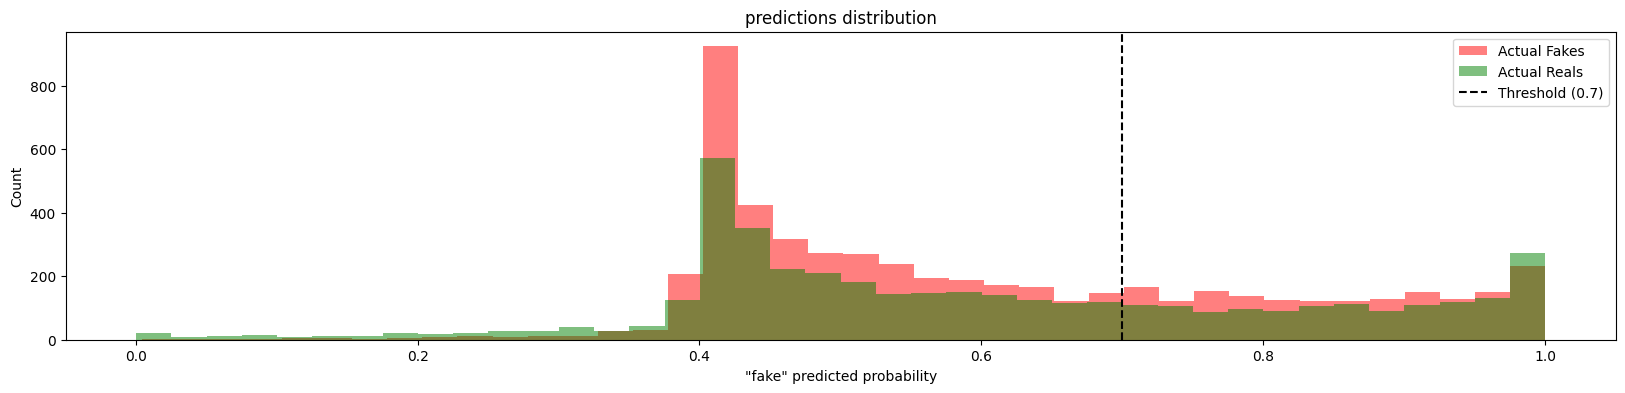

In [28]:
# Visualisation
plt.figure(figsize=(20, 4))


plt.hist(probas_fake, bins=40, alpha=0.5, label='Actual Fakes', color='red')
plt.hist(probas_real, bins=40, alpha=0.5, label='Actual Reals', color='green')
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold ({threshold})')

plt.xlabel('"fake" predicted probability')
plt.ylabel('Count')
plt.legend()
plt.title('predictions distribution')
plt.show()